# Preliminaries

In [3]:
import numpy as np
from numpy import random as rd
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.rcParams['figure.figsize'] = [10, 6]

# Supplied code:

from numpy import pi, sqrt, log, exp

#
# Normal cumulative distribution function, with extension
# for complex argument with small imaginary component
#


def norm_cdf(x):
    if not isinstance(x, np.ndarray):
        xr = x.real
        xi = x.imag
        if abs(xi) > 1.0e-10:
            raise ValueError("imag(x) too large in norm_cdf(x)")

        ncf = norm.cdf(xr)
        if abs(xi) > 0:
            ncf = ncf + 1.0j * xi * norm.pdf(xr)
    else:
        xr = np.real(x)
        xi = np.imag(x)
        if any(abs(xi) > 1.0e-10):
            raise ValueError("imag(x) too large in norm_cdf(x)")

        ncf = norm.cdf(xr)
        if any(abs(xi) > 0):
            ncf = ncf + 1.0j * xi * norm.pdf(xr)

    return ncf


# V = european_call(r,sigma,T,S,K,opt)
#
# Black-Scholes European call option solution
# as defined in equation (3.17) on page 48 of
# The Mathematics of Financial Derivatives
# by Wilmott, Howison and Dewynne
#
# r     - interest rate
# sigma - volatility
# T     - time interval
# S     - asset value(s)  (float or flattened numpy array)
# K     - strike price(s) (float or flattened numpy array)
# opt   - 'value', 'delta', 'gamma' or 'vega'
# V     - option value(s) (float or flattened numpy array)
#


def european_call(r, sigma, T, S, K, opt):

    S = S + 1.0e-100  # avoids problems with S=0
    K = K + 1.0e-100  # avoids problems with K=0

    d1 = (log(S) - log(K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S) - log(K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))

    if opt == "value":
        V = S * norm_cdf(d1) - exp(-r * T) * K * norm_cdf(d2)
    elif opt == "delta":
        V = norm_cdf(d1)
    elif opt == "gamma":
        V = exp(-0.5 * d1 ** 2) / (sigma * sqrt(2 * pi * T) * S)
    elif opt == "vega":
        V = S * (exp(-0.5 * d1 ** 2) / sqrt(2 * pi)) * (sqrt(T) - d1 / sigma) - exp(
            -r * T
        ) * K * (exp(-0.5 * d2 ** 2) / sqrt(2 * pi)) * (-sqrt(T) - d2 / sigma)

    else:
        raise ValueError(
            'invalid value for opt -- must be "value", "delta", "gamma", "vega"'
        )

    return V

# Weak convergence - comparison with exact solution

In [9]:
#
# Test weak convergence of Euler method
# for European call option
#
# Test problem:   dS   = r*S dt + sig*S dW
#

#
# problem parameters and exact solution
#

r, sig, T, S0, K = 0.05, 0.5, 1, 100, 110

Ve  = european_call(r,sig,T,S0,K,'value')

def european_call_payoff(S):
    return np.exp(-r*T) * np.maximum(S - K, 0)

#
# Monte Carlo simulation comparing to exact solution 
#

M  = 10 ** 7   # total number of Monte Carlo paths, not using 10e7 notation to keep M an int
M2 = 10 ** 4   # number of paths at a time, set in accordance with memory available

hh, err1, err2 = np.empty(0), np.empty(0), np.empty(0)

for p in range(1, 7):
    N = 2**p # number of time steps
    h = T/N # time step size

    sum1 = 0 # sum of estimates
    sum2 = 0 # sum of squares estimates
    

    for m in range(0, M, M2):
        m2 = min(M2, M - m)
        # m keeps track of the number of paths already simulated.
        # m2 is the number of paths to simulate this loop.
        # Note m2 will be equal to M2 apart from the last loop,
        # where we use only enough paths to get exactly M paths in total.
        
        S = S0 * np.ones(m2)
        
        for _ in range(N):
            dW = np.sqrt(h)*rd.randn(m2)
            S  = S*(1+r*h+sig*dW)   

        P = european_call_payoff(S)

        sum1 = sum1 + np.sum(P)
        sum2 = sum2 + np.sum(P**2)

    V  = sum1/M
    sd = np.sqrt((sum2/M - V**2)/(M-1))

    hh, err1, err2 = np.append(hh,h), np.append(err1,V-Ve), np.append(err2,3*sd)

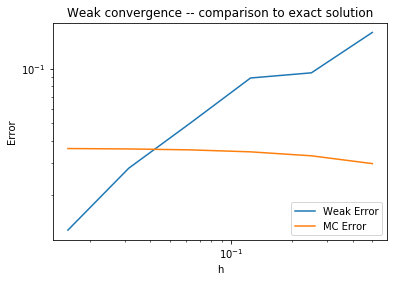

In [10]:
plt.loglog(hh, np.abs(err1), label="Weak Error")
plt.loglog(hh, err2, label="MC Error")
plt.title("Weak convergence -- comparison to exact solution")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

# Weak error - comparison between $2h$ and $h$ path

In [16]:
#
# Monte Carlo simulation comparing to 2h simulaton 
#

M  = 10**7   # total number of Monte Carlo paths
M2 = 10**4   # number of paths at a time 

hh, err1, err2 = np.empty(0), np.empty(0), np.empty(0)

for p in range(1, 8):
    N = 2**p
    h = T/N

    sum1 = 0 # sum of difference between processes with step sizes 2h and h
    sum2 = 0 # sum of square differences between processes with step sizes 2h and h

    for m in range(0, M, M2):
        m2 = min(M2, M-m)
        
        S, S2 = S0*np.ones(m2), S0*np.ones(m2)
        
        for _ in range(N//2):
            dW1 = np.sqrt(h)*rd.randn(m2)
            S  = S*(1+r*h+sig*dW1)
            dW2 = np.sqrt(h)*rd.randn(m2)
            S  = S*(1+r*h+sig*dW2)
            
            S2  = S2*(1+r*2*h+sig*(dW1+dW2))
            
        P = european_call_payoff(S)
        P2 = european_call_payoff(S2)

        sum1 = sum1 + np.sum(P-P2)
        sum2 = sum2 + np.sum((P-P2)**2)

    Vd  = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))

    hh, err1, err2 = np.append(hh,h), np.append(err1,Vd), np.append(err2,3*sd)

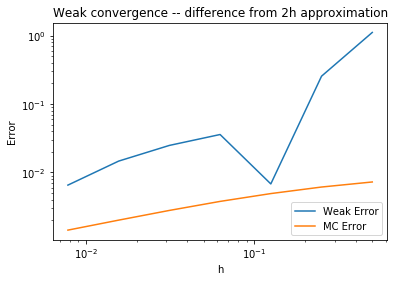

In [17]:
plt.loglog(hh, np.abs(err1), label="Weak Error")
plt.loglog(hh, err2, label="MC Error")
plt.title("Weak convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

# Strong Error

In [6]:
def euler_maruyama(drift, diffusion,
                   initial_value, terminal_time, steps, paths,
                   paths_per_loop = None,
                   soln_dim = 1, driving_dim = 1,
                   exact_soln = None):
    
    """
    Simulates the solution S of the SDE
    dS = a(S)*dt + b(S)*dW
    where a is a drift term and b is a diffusion term started from S[0]. We use the
    Euler-Maruyama approximation scheme to numerically solve the SDE. Returns an
    approximation of the strong error.
    
    Parameters
    ----------
    drift : 
        The drift term a in the SDE
    diffusion :
        The diffusion term b in the SDE
    initial_value :
        The initial value S[0] of the path
    terminal_tume :
        The terminal time T the payoff is based on
    steps :
        The number of steps to use the Euler-Maruyama approximation scheme
    soln_dim :
        The dimensions of the SDE solution
    driving_dim :
        The dimensions of the driving Brownian motion
    exact_soln :
        A function which generates the exact solution from the terminal value
        of the Brownian path. If this exists we return also strong errors
        compared to the exact value.

    Returns
    -------
    float :
        Estimated strong error
    float :
        Estimated sd of the strong error estimator
    """
    
    N = steps
    T = terminal_time
    h = T/N
    M = paths
    if M2 == None:
        M2 = M
    
    def update(S, h, dW):
        return drift(S) * h + np.einsum('ijk, ik -> ij', diffusion(S), dW)

    sum1, sum2 = 0, 0

    for m in range(0, M, M2):
        m2 = min(M2, M - m)
        
        S1 = S0*np.ones((m2, soln_dim))
        S2 = S0*np.ones((m2, soln_dim))
        W = np.zeros((m2, driving_dim))
        
        for _ in range(N//2):
            dW1 = np.sqrt(h)*rd.randn(m2, driving_dim)
            dW2 = np.sqrt(h)*rd.randn(m2, driving_dim)
            
            S1 = update(S1, h, dW1)
            S1 = update(S1, h, dW2)
            S2 = update(S2, 2*h, dW1 + dW2)      
            W += dW1 + dW2
        
        if exact_soln != None:
            Se = exact_soln(W)
            diff = np.sum((Se - S1)**2, axis=1) # L2 squared distance between exact and approximate
        else:
            diff = np.sum((S2 - S1)**2, axis=1)
            
        sum1 += np.sum(diff)
        sum2 += np.sum(diff**2)
        
    strong_error  = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))
    
    return strong_error, sd

In [4]:
#
# Test strong convergence of Euler method
# for solving stochastic o.d.e.'s
#
# Test problem:   dS   = r*S dt + sig*S dW
# Exact solution: S(1) = S(0)*exp((lambda-0.5*sig^2)+sig*W(1))
#

#
# problem parameters
#

[r, sig, T, S0]   = [0.05, 0.5, 1, 100] 

#
# Monte Carlo simulation comparing to 2h simulation
#

M  = 1e5   # total number of Monte Carlo paths
M2 = 1e4   # number of paths at a time 

[hh, err1, err2, err3, err4] = [np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.empty(0)]

for p in range(1, 8):
    N = 2**p
    h = T/N

    [sum1, sum2, sum3, sum4] = [0, 0, 0, 0]
    

    for m in np.linspace(1,(M/M2 -1) *M2 + 1,num = M//M2):
        
        m2 = int(np.min([M2, M-m+1]))
        [S, S2, W] = [S0*np.ones((1,m2)), S0*np.ones((1,m2)), 0]
        
        
        for n in range(1,N //2+1):
            dW1 = np.sqrt(h)*rd.randn(1,m2)
            S  = S*(1+r*h+sig*dW1)
            dW2 = np.sqrt(h)*rd.randn(1,m2)
            S  = S*(1+r*h+sig*dW2)
            
            S2  = S2*(1+r*2*h+sig*(dW1+dW2))
            
            W = W + dW1 + dW2
            
        Se = S0*exp((r-0.5*sig**2)*T + sig*W)
        
        de1 = (Se-S)**2
        sum1 = sum1 + np.sum(de1)
        sum2 = sum2 + np.sum(de1**2)

        de1 = (S2-S)**2
        sum3 = sum3 + np.sum(de1)
        sum4 = sum4 + np.sum(de1**2)
        
        
    Vd  = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))
    
    [hh, err1, err2] = [np.append(hh,h),np.append(err1,sqrt(Vd)),np.append(err2,0.5 *3*sd / sqrt(Vd))]
    
    Vd = sum3/M
    sd = np.sqrt((sum4/M - (sum3/M)**2)/(M-1))
    
    [err3, err4] = [np.append(err3,sqrt(Vd)),np.append(err4,0.5 *3*sd / sqrt(Vd))]

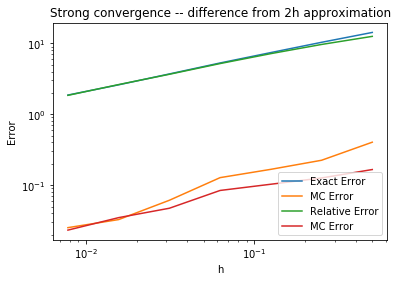

In [5]:
plt.loglog(hh, np.abs(err1), label="Exact Error")
plt.loglog(hh, err2, label="MC Error")
plt.loglog(hh, np.abs(err3), label="Relative Error")
plt.loglog(hh, err4, label="MC Error")
plt.title("Strong convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

#  Ornstein-Uhlenbeck Process

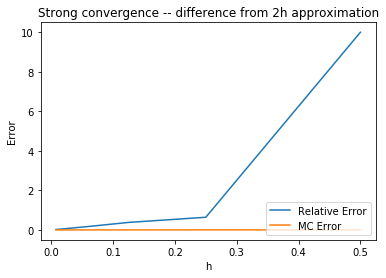

In [37]:
#
# Test strong convergence of Euler method
# for solving stochastic o.d.e.'s
#
# Test problem:   dS   = kappa*(theta - S) dt + sig*dW
#

#
# problem parameters
# 

[kappa, theta, T, S0, sig]   = [2, 110, 1, 100, 0.5] 

#
# Monte Carlo simulation comparing to 2h simulation
#

M  = 1e5   # total number of Monte Carlo paths
M2 = 1e4   # number of paths at a time 

[hh, err3, err4] = [np.empty(0), np.empty(0), np.empty(0)]

for p in range(1, 8):
    N = 2**p
    h = T/N

    [sum3, sum4] = [0, 0]
    
    for m in np.linspace(1,(M/M2 -1) *M2 + 1,num = M//M2):
        
        m2 = int(np.min([M2, M-m+1]))
        [S, S2] = [S0*np.ones((1,m2)), S0*np.ones((1,m2))]
        
        
        for n in range(1,N //2+1):
            dW1 = np.sqrt(h)*rd.randn(1,m2)
            S  = S + kappa*(theta- S)*h + sig*dW1
            dW2 = np.sqrt(h)*rd.randn(1,m2)
            S  = S + kappa*(theta- S)*h + sig*dW2
            
            S2  = S2 + kappa*(theta- S2)*2*h + sig*(dW1+dW2)
            
        de1 = (S2-S)**2
        sum3 = sum3 + np.sum(de1)
        sum4 = sum4 + np.sum(de1**2)
        
    Vd = sum3/M
    sd = np.sqrt((sum4/M - (sum3/M)**2)/(M-1))
    
    [hh, err3, err4] = [np.append(hh,h),np.append(err3,sqrt(Vd)),np.append(err4,0.5 *3*sd / sqrt(Vd))]

plt.plot(hh, np.abs(err3), label="Relative Error")
plt.plot(hh, err4, label="MC Error")
plt.title("Strong convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

## Heston Model

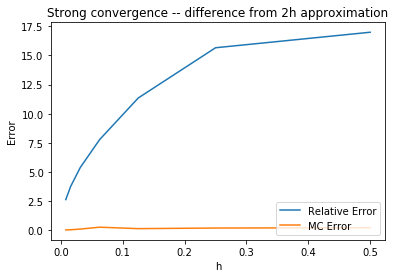

In [70]:
#
# Test strong convergence of Euler method
# for solving stochastic o.d.e.'s
#
# Test problem:   dS   = r*S dt + sqrt(abs(v))*S dW1
#                 dv   = kappa*(theta-v)dt + eta*sqrt(abs(v))*(rho dW1 + sqrt(1-rho**2) dW2
# where W1 and W2 are independent Brownian motions.
#

#
# problem parameters
#

[kappa, theta, T, S0, v0, eta, rho, r]   = [2, 0.25, 1, 100, 0.25, 0.5, -0.1, 0.05]

#
# Monte Carlo simulation comparing to 2h simulation
#

M  = 1e5   # total number of Monte Carlo paths
M2 = 1e4   # number of paths at a time 

[hh, err3, err4] = [np.empty(0), np.empty(0), np.empty(0)]

for p in range(1, 8):
    N = 2**p
    h = T/N

    [sum3, sum4] = [0, 0]
    
    for m in np.linspace(1,(M/M2 -1) *M2 + 1,num = M//M2):
        
        m2 = int(np.min([M2, M-m+1]))
        [S, S2, v, v2] = [S0*np.ones((1,m2)), S0*np.ones((1,m2)), v0*np.ones((1,m2)), v0*np.ones((1,m2))]
        
        
        for n in range(1,N //2+1):
            dW1 = np.sqrt(h)*rd.randn(1,m2)
            dW1_star = np.sqrt(h)*rd.randn(1,m2)
            dW2 = np.sqrt(h)*rd.randn(1,m2)
            dW2_star = np.sqrt(h)*rd.randn(1,m2)
            
            S  = S + r*S*h + np.sqrt(np.abs(v))*S*dW1
            v  = v + kappa*(theta-v)*h + eta*np.sqrt(np.abs(v))*(rho*dW1 +np.sqrt(1-rho**2)*dW1_star)
            S  = S + r*S*h + np.sqrt(np.abs(v))*S*dW2
            v  = v + kappa*(theta-v)*h + eta*np.sqrt(np.abs(v))*(rho*dW2 +np.sqrt(1-rho**2)*dW2_star)
            
            S2  = S2 + r*S2*2*h + np.sqrt(np.abs(v2))*S2*(dW1 + dW2)
            v2 = v2 + kappa*(theta-v2)*2*h + eta*np.sqrt(np.abs(v2))*(rho*(dW1+dW2) +np.sqrt(1-rho**2)*(dW1_star+dW2_star))
                
        de1 = (S2-S)**2
        sum3 = sum3 + np.sum(de1)
        sum4 = sum4 + np.sum(de1**2)
        
    Vd = sum3/M
    sd = np.sqrt((sum4/M - (sum3/M)**2)/(M-1))
    
    [hh, err3, err4] = [np.append(hh,h),np.append(err3,sqrt(Vd)),np.append(err4,0.5 *3*sd / sqrt(Vd))]

plt.plot(hh, np.abs(err3), label="Relative Error")
plt.plot(hh, err4, label="MC Error")
plt.title("Strong convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()